# Sales Prediction Forcast
Australia Company Sales Forcast, Funmed Data Scientist Interview

## Data 
The features in the dataset are:

- `store_id`: An integer ID for each store 
- `date`: The date in year-month-day format (string)
- `is_store_open`: Binary variable indicating if the store is open on this date or not (1 = open)
- `is_sale_period`: Binary variable indicating if the store has an ongoing sale (1 = yes)
- `town`: Name of the (fictitious) town

The outcome variables are:

- `n_cust`: The number of customers who visited the store on the given date
- `revenue`: The total revenue that was earned by the store on the given date

## Datasets
- Training data `sales_data.csv`
- Test data `sales_data_forecast.csv`

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import warnings

import time

%matplotlib inline

sb.set_style("white")

# Data Gathering

In [2]:
def load_data(path=None):    
    data = pd.read_csv(path)
    return data
    #pred_data = pd.read_csv('./data/sales_data_forecast.csv')    
    #return data, pred_data

def business_info(df):
    
    '''Initial info screen'''
    
    print(f'Number of stores: {df.store_id.nunique()}')
    print(f'Number of towns: {df.town.nunique()}')
    print(f'Dates: {df.date.min()} - {df.date.max()}')
    print(f'Nr of days: {df.date.nunique()}')
    print(f'Percent open: {round(df.is_store_open.sum()/df.shape[0]*100,2)} %')
    print(f'Percent sale period: {round(df.is_sale_period.sum()/df.shape[0]*100,2)} %')
    
    if 'n_cust' in df.columns:
        print(f'Number of customers: {df.n_cust.min()} - {df.n_cust.max()}')
    
    if 'revenue' in df.columns:
        print(f'Revenue: {df.revenue.min()} - {df.revenue.max()} Au$?')

    return

def df_info(data):
    
    print(data.info())
    print('\n')
    print('Nr na values per column:')
    print(data.isna().sum())
    print('\n')
    print(f'Nr duplicates: {data.duplicated().sum()}')
    print('\n')
    print('Statistics:')

    return data[data.columns.drop('store_id')].describe()


In [3]:
# load data
data = load_data(path='./data/sales_data.csv')
pred_data = load_data(path='./data/sales_data_forecast.csv').iloc[:,1:]
data.head()

store_id        date  is_store_open  is_sale_period            town  \
0       418  2011-04-01              1               0           Dukem   
1       119  2009-08-03              1               0  Yepthton Beach   
2       791  2010-08-16              1               0           Dukem   
3       355  2011-09-02              1               0           Dukem   
4       624  2011-09-15              1               0  Yepthton Beach   

   n_cust  revenue  
0    1053     8828  
1     871     6469  
2     901     7186  
3    1838    16505  
4     804     7963

In [4]:
data.sort_values(by='date')

store_id        date  is_store_open  is_sale_period  \
186655       927  2009-07-07              0               0   
586989       477  2009-07-07              0               0   
181662       303  2009-07-07              0               0   
833169       806  2009-07-07              0               0   
553484       751  2009-07-07              0               0   
...          ...         ...            ...             ...   
813305       946  2011-12-31              1               0   
339386       211  2011-12-31              1               0   
845437       270  2011-12-31              1               0   
58821        720  2011-12-31              1               0   
301539       940  2011-12-31              1               0   

                      town  n_cust  revenue  
186655      Yepthton Beach       0        0  
586989               Dukem       0        0  
181662          Balntermou       0        0  
833169                 Ood       0        0  
553484  Port Shamlakesmark       0        0  
...                    ...     ...      ...  
813305               Dukem     510     4227  
339386               Dukem    1607    14338  
845437      Yepthton Beach    1386    11310  
58821       Yepthton Beach     643     6352  
301539      Yepthton Beach     610     6017  

[885995 rows x 7 columns]

## General info

In [5]:
# business intro
print('-------------------')
print('Business info:')
print('-------------------')
business_info(data)

-------------------
Business info:
-------------------
Number of stores: 1009
Number of towns: 20
Dates: 2009-07-07 - 2011-12-31
Nr of days: 908
Percent open: 82.9 %
Percent sale period: 37.92 %
Number of customers: 0 - 10065
Revenue: 0 - 70935 Au$?


In [6]:
# train data df intro
print('-------------------')
print('Dataset info:')
print('-------------------')
df_info(data)

-------------------
Dataset info:
-------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885995 entries, 0 to 885994
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   store_id        885995 non-null  int64 
 1   date            885995 non-null  object
 2   is_store_open   885995 non-null  int64 
 3   is_sale_period  885995 non-null  int64 
 4   town            885995 non-null  object
 5   n_cust          885995 non-null  int64 
 6   revenue         885995 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 47.3+ MB
None


Nr na values per column:
store_id          0
date              0
is_store_open     0
is_sale_period    0
town              0
n_cust            0
revenue           0
dtype: int64


Nr duplicates: 0


Statistics:


is_store_open  is_sale_period         n_cust        revenue
count  885995.000000   885995.000000  885995.000000  885995.000000
mean        0.829045        0.379200     778.333163    7099.252841
std         0.376470        0.485188     646.005572    5370.207670
min         0.000000        0.000000       0.000000       0.000000
25%         1.000000        0.000000     398.000000    3593.000000
50%         1.000000        0.000000     713.000000    6680.000000
75%         1.000000        1.000000    1054.000000    9929.000000
max         1.000000        1.000000   10065.000000   70935.000000

### Gather Test Data

In [7]:
# view test data
pred_data

store_id        date  is_store_open  is_sale_period             town  \
0             1  2012-02-03              1               1   Yepthton Beach   
1             2  2012-02-03              1               1   Yepthton Beach   
2             3  2012-02-03              1               1            Dukem   
3             4  2012-02-03              1               1   Yepthton Beach   
4             5  2012-02-03              1               1  Mount Trancesmi   
...         ...         ...            ...             ...              ...   
34301      1005  2012-01-01              0               0        Port Shep   
34302      1006  2012-01-01              0               0       Balntermou   
34303      1007  2012-01-01              0               0            Dukem   
34304      1008  2012-01-01              0               0  Mount Trancesmi   
34305      1009  2012-01-01              0               0            Dukem   

       n_cust_pred  revenue_pred  
0         846.7900   8543.168000  
1         846.7900   8543.168000  
2        1138.8397  11822.802000  
3        1350.9313  10112.207000  
4         795.7609   7011.723000  
...            ...           ...  
34301       0.0000      0.000000  
34302       0.0000     43.476345  
34303       0.0000     61.405148  
34304       0.0000      0.000000  
34305       0.0000     39.238487  

[34306 rows x 7 columns]

In [8]:
# business intro
business_info(pred_data)

Number of stores: 1009
Number of towns: 20
Dates: 2012-01-01 - 2012-02-03
Nr of days: 34
Percent open: 85.57 %
Percent sale period: 44.12 %


In [9]:
# pred_data df intro
df_info(pred_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34306 entries, 0 to 34305
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   store_id        34306 non-null  int64  
 1   date            34306 non-null  object 
 2   is_store_open   34306 non-null  int64  
 3   is_sale_period  34306 non-null  int64  
 4   town            34306 non-null  object 
 5   n_cust_pred     34306 non-null  float64
 6   revenue_pred    34306 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 1.8+ MB
None


Nr na values per column:
store_id          0
date              0
is_store_open     0
is_sale_period    0
town              0
n_cust_pred       0
revenue_pred      0
dtype: int64


Nr duplicates: 0


Statistics:


is_store_open  is_sale_period   n_cust_pred  revenue_pred
count   34306.000000    34306.000000  34306.000000  34306.000000
mean        0.855710        0.441176    808.099593   7469.909785
std         0.351388        0.496535    537.347341   4451.548982
min         0.000000        0.000000      0.000000      0.000000
25%         1.000000        0.000000    611.944800   5428.593300
50%         1.000000        0.000000    826.522480   7998.655000
75%         1.000000        1.000000   1029.427600  10011.611000
max         1.000000        1.000000   7171.054700  43777.684000

# Exploratory Data Analysis

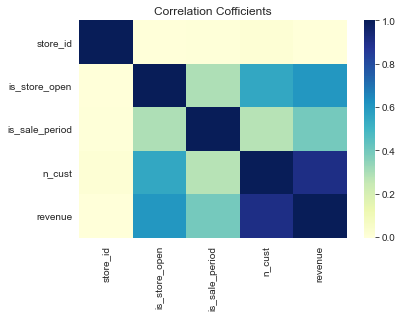

In [10]:
# Correlation
sb.heatmap(data.corr(), cmap="YlGnBu");
plt.title('Correlation Cofficients');
plt.savefig(f'./visuals/corr_coef_base.png', bbox_inches='tight')

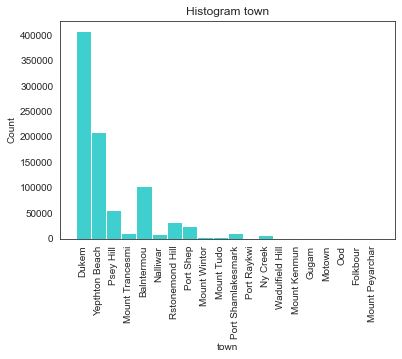

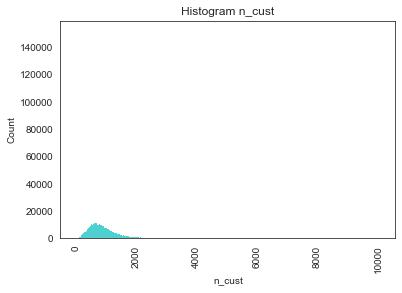

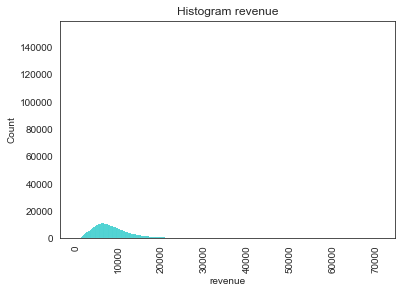

In [11]:
# Univariate plots
def univariate_plots(df):
    histplots = df.columns.drop(['store_id', 'date', 'is_store_open', 'is_sale_period'])
    for i in histplots:
        sb.histplot(df, x=i, color='c')
        plt.title(f'Histogram {i}')
        plt.xticks(rotation=90)
        plt.savefig(f'./visuals/histogram_{i}.png', bbox_inches='tight')
        plt.show()
    return

univariate_plots(data)

In [ ]:
# year plots
data.date = pd.to_datetime(data.date)

start_date = '2011-01-01'
end_date = '2011-12-31'
response = ['n_cust', 'revenue']

resp = response[0]
plt.figure(figsize=(50,10))
plotdf = data[(data.date > start_date) & (data.date < end_date)].groupby(by=data.date).sum()
plt.plot(plotdf.index.autoformatter.month, plotdf[resp], linewidth = 2);
plt.title(f'{resp} per day')
plt.savefig(f'./visuals/timeserie_{resp}_{start_date}_{end_date}.png', bbox_inches='tight')
plt.show()

resp = response[1]
plt.figure(figsize=(50,10))
plotdf = data[(data.date > start_date) & (data.date < end_date)].groupby(by=data.date).sum()
plt.plot(plotdf.index.autoformatter.month, plotdf[resp], linewidth = 2);
plt.title(f'{resp} per day')
plt.savefig(f'./visuals/timeserie_{resp}_{start_date}_{end_date}.png', bbox_inches='tight')
plt.show()

In [ ]:
# month plots
start_date = '2011-03-01'
end_date = '2011-03-31'
response = ['n_cust', 'revenue']

resp = response[0]
plt.figure(figsize=(50,10))
plotdf = data[(data.date > start_date) & (data.date < end_date)].groupby(by=data.date).sum()
plt.plot(plotdf.index, plotdf[resp], linewidth = 2);
plt.title(f'{resp} per day')
plt.savefig(f'./visuals/timeserie_{resp}_{start_date}_{end_date}.png', bbox_inches='tight')
plt.show()

resp = response[1]
plt.figure(figsize=(50,10))
plotdf = data[(data.date > start_date) & (data.date < end_date)].groupby(by=data.date).sum()
plt.plot(plotdf.index.autoformatter.month, plotdf[resp], linewidth = 2);
plt.title(f'{resp} per day')
plt.savefig(f'./visuals/timeserie_{resp}_{start_date}_{end_date}.png', bbox_inches='tight')
plt.show()

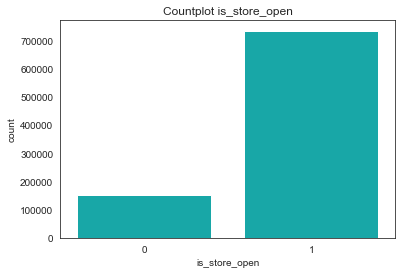

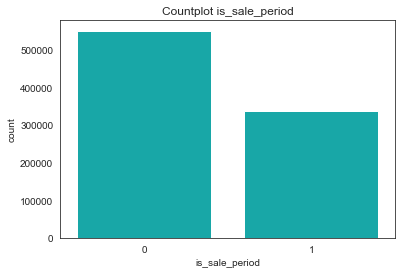

In [14]:
def count_plots(df):
    for i in df.columns[df.nunique() <= 3]:
        sb.countplot(data=df, x=i, color='c');
        plt.title(f'Countplot {i}');
        plt.savefig(f'./visuals/countplot_{i}.png', bbox_inches='tight')
        plt.show();
        
count_plots(data)

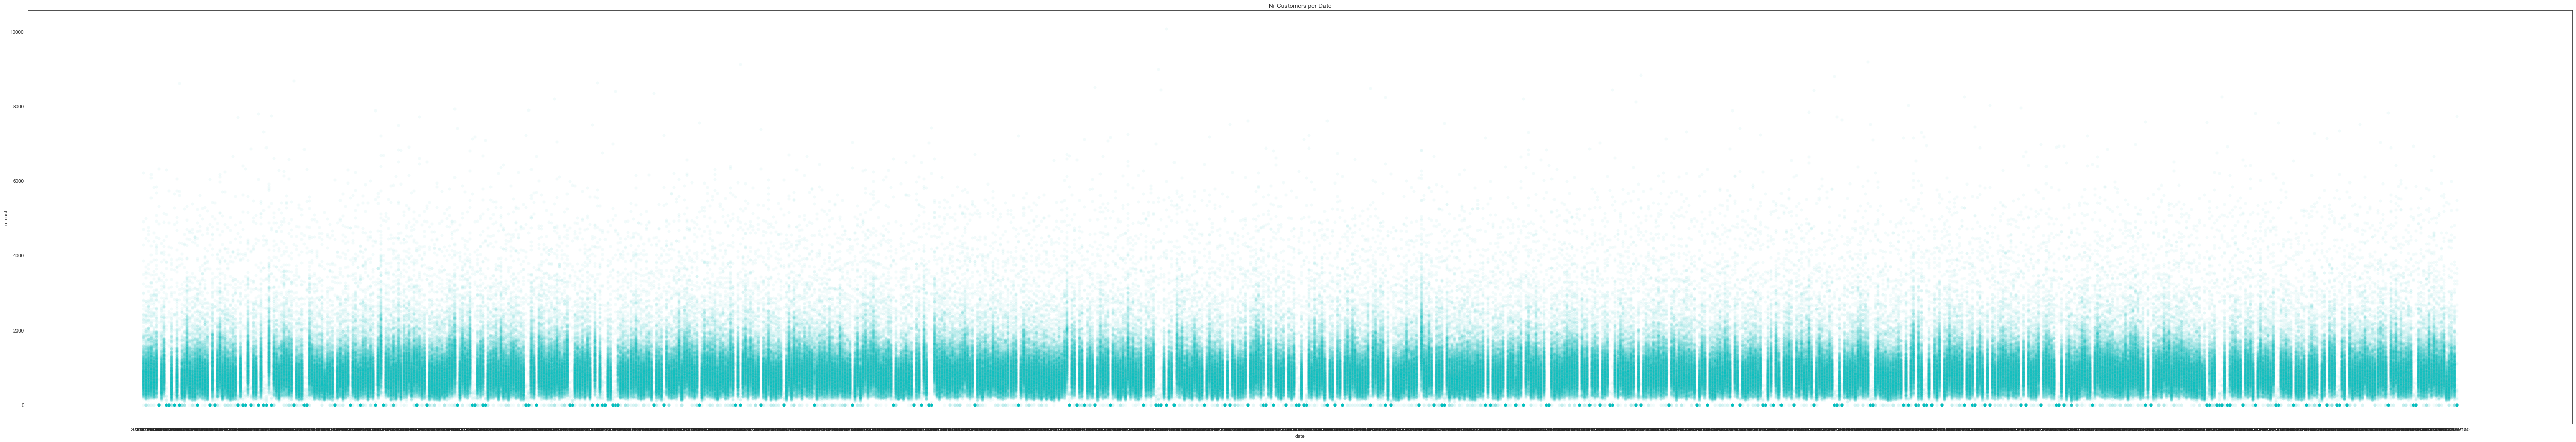

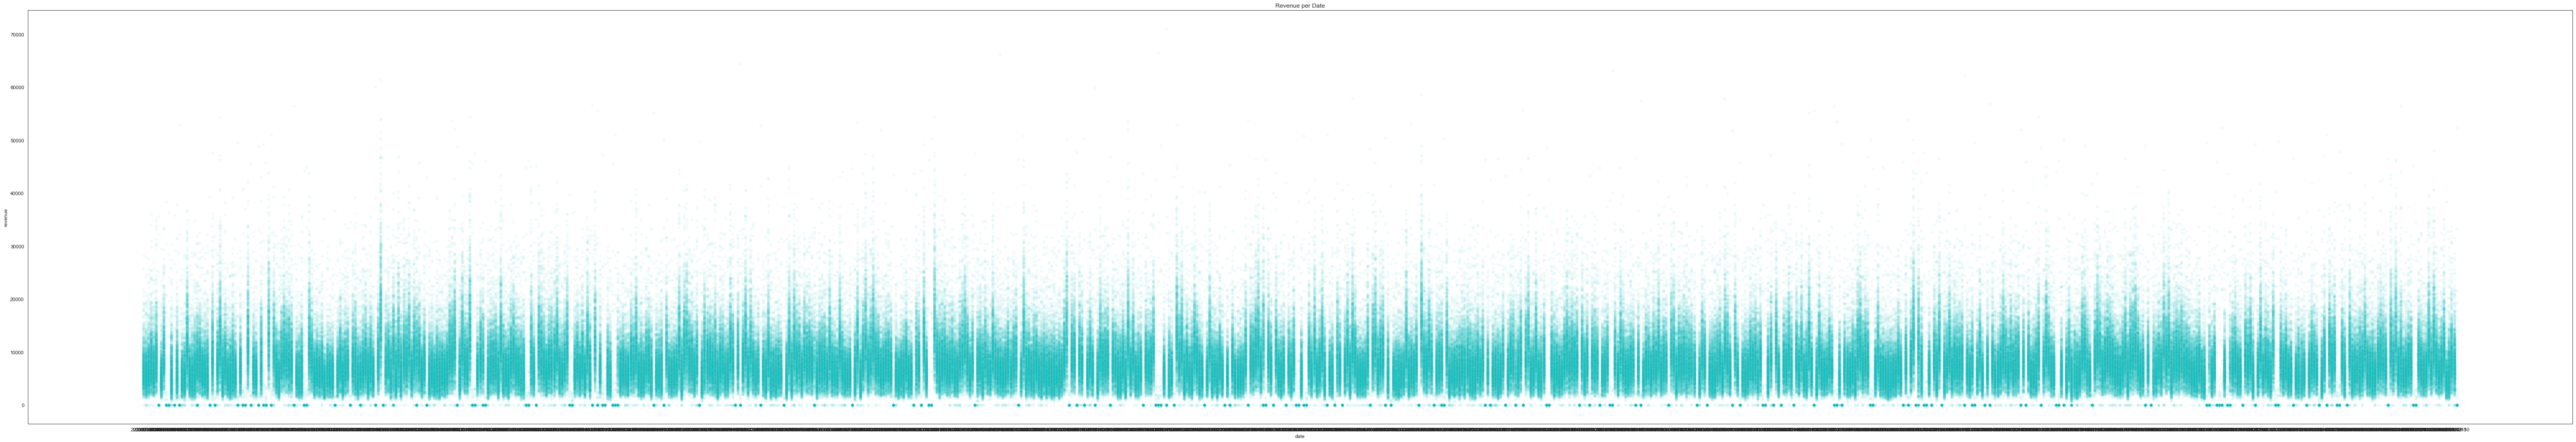

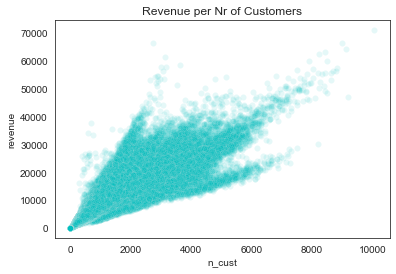

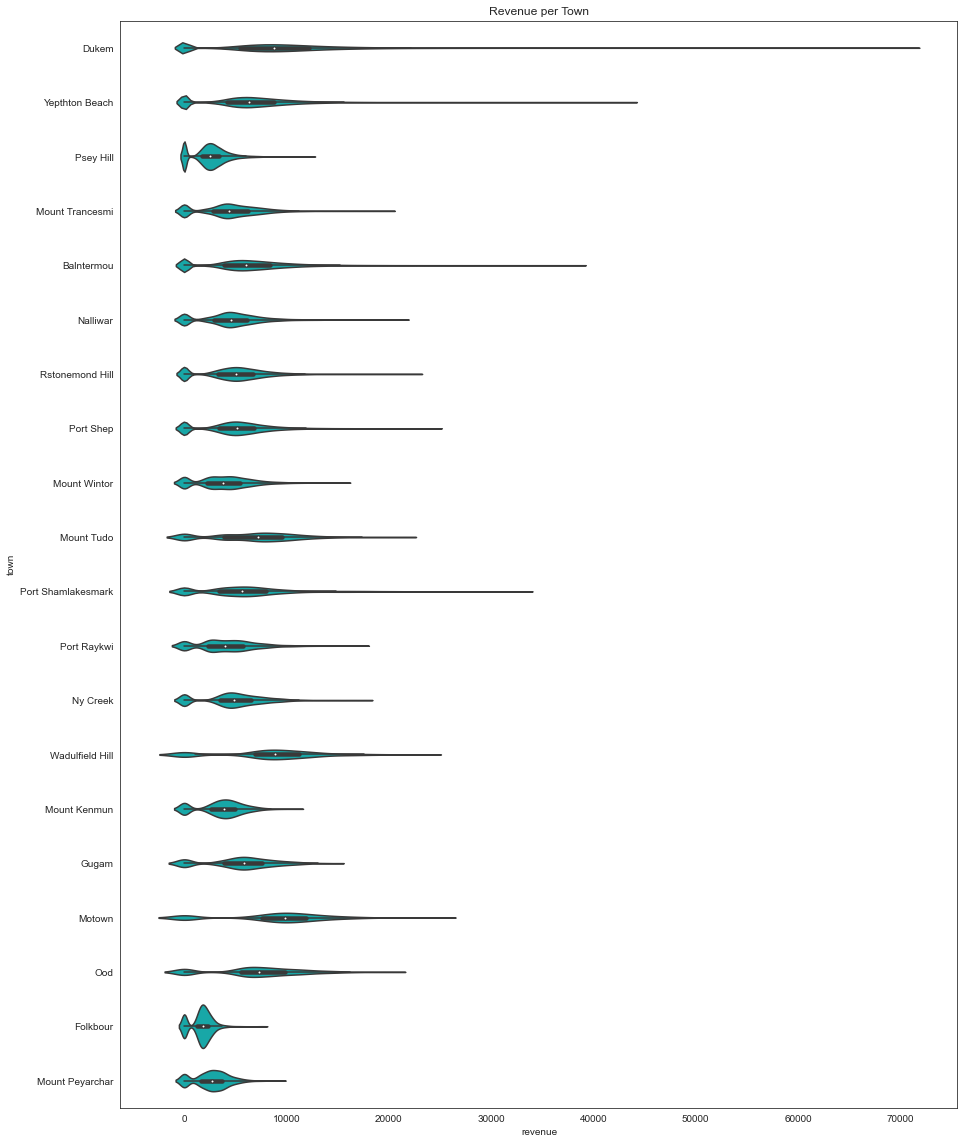

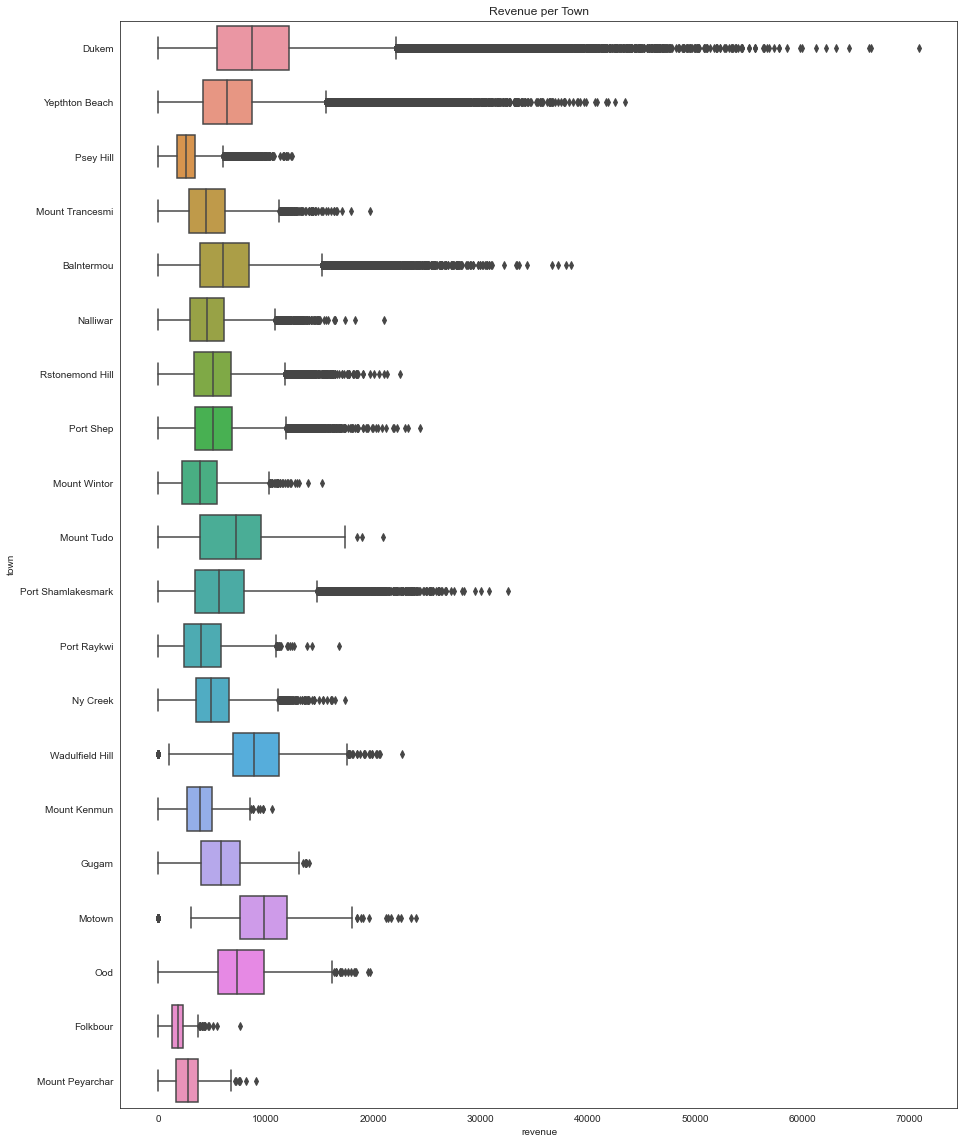

In [15]:
def bivar_plots(df):
    
    # time serie response 1
    plt.figure(figsize=(90,15))
    sb.scatterplot(data = df, y = 'n_cust', x = 'date', color='c', alpha=0.05);
    plt.title('Nr Customers per Date');
    plt.savefig(f'./visuals/timeserie_n_cust.png', bbox_inches='tight')
    plt.show();
    
    # time serie response 2
    plt.figure(figsize=(90,15))
    sb.scatterplot(data = df, y = 'revenue', x = 'date', color='c', alpha=0.05);
    plt.title('Revenue per Date');
    plt.savefig(f'./visuals/timeserie_revenue.png', bbox_inches='tight')
    plt.show();
    
    # scatterplot responses
    sb.scatterplot(data = df, y = 'revenue', x = 'n_cust', color='c', alpha=0.1);
    plt.title('Revenue per Nr of Customers');
    plt.savefig(f'./visuals/scatterplot_responses.png', bbox_inches='tight')
    plt.show();
    
    # violoinplot revenue per store
    plt.figure(figsize=(15,20))
    sb.violinplot(data=df, y = 'town', x = 'revenue', color='c');
    plt.title('Revenue per Town')
    plt.savefig(f'./visuals/violoinplot_revenue_store.png', bbox_inches='tight')
    plt.show();
    
    # boxplot revenue per store
    plt.figure(figsize=(15,20))
    sb.boxplot(data=df, x='revenue', y='town');
    plt.title('Revenue per Town')
    plt.savefig(f'./visuals/boxplot_revenue_store.png', bbox_inches='tight')
    plt.show();
    
    return
    
bivar_plots(data)

In [16]:
def pair_plot(df):
    
    pair_list = df[df.columns.drop(['is_store_open'])]
    sb.pairplot(pair_list)
    plt.title('Pairplot')
    plt.savefig(f'./pairplot.png', bbox_inches='tight')
    
    return

#pair_plot(data)

# Feature Engineering
Add ordinal columns for:
1. Year
1. Month
1. Week of year
1. Week of month
1. Quarter
1. Season
1. (Holidays)

In [26]:
data_copy = data.copy() 
data_copy.head()

store_id        date  is_store_open  is_sale_period            town  \
0       418  2011-04-01              1               0           Dukem   
1       119  2009-08-03              1               0  Yepthton Beach   
2       791  2010-08-16              1               0           Dukem   
3       355  2011-09-02              1               0           Dukem   
4       624  2011-09-15              1               0  Yepthton Beach   

   n_cust  revenue  
0    1053     8828  
1     871     6469  
2     901     7186  
3    1838    16505  
4     804     7963

In [27]:
def add_date_features(df):
    warnings.filterwarnings("ignore")
    
    # change date dtype to datetime
    df.date = pd.to_datetime(df.date)
    
    # create date features
    df['season'] = np.nan # assigned in the loop below
    df['quarter'] = df.date.dt.quarter
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['week_of_year'] = df.date.dt.week
    df['week_of_month'] = np.nan # assign in the loop below
    df['weekday'] = df.date.dt.dayofweek # mon = 0, sun = 6

    # assign season 
    # December to February is summer; March to May is autumn; June to August is winter; and September to November is spring. 
    
    for idx, val in enumerate(data.date):
        
        date = datetime.strptime(val, '%Y-%m-%d') # convert str to datetime

        # summer = 1, autumn = 2, winter = 3, spring = 4
        if date.month == 12 or date.month <=2:
            df['season'][idx] = 1
        elif date.month > 2 and date.month <= 5:
            df['season'][idx] = 2
        elif date.month > 5 and date.month <= 8:
            df['season'][idx] = 3
        elif date.month > 8 and date.month <= 11:
            df['season'][idx] = 4
    
    # assign week of month
    for idx, val in enumerate(data.date):

        date = datetime.strptime(val, '%Y-%m-%d') # convert str to datetime
        
        if date.day <= 7:
            df['week_of_month'][idx] = 1
        elif date.day > 7 and date.day <= 14:
            df['week_of_month'][idx] = 2
        elif date.day > 14 and date.day <= 21:
            df['week_of_month'][idx] = 3
        elif date.day > 21 and date.day <= 28:
            df['week_of_month'][idx] = 4
        else:
            df['week_of_month'][idx] = 5
    
    return df


In [28]:
# add date features
start_time = time.time()
data_copy = add_date_features(data_copy)
end_time = time.time()
print(f'Elapsed time = {end_time - start_time} seconds ... ')

KeyboardInterrupt: 

In [ ]:
# drop date?
df.drop('date', axis=1, inplace=True)

In [ ]:
# save
data_copy.to_csv('./data/data_feat_extention.csv')
data_copy.head()

# Pre-Processing
- One-Hot-Encoding of store_id and town
- Split data

In [29]:
f_data = load_data('./data/data_feat_extention.csv')
feat_data = f_data.copy().iloc[:,1:]
feat_data.head()

store_id  is_store_open  is_sale_period            town  n_cust  revenue  \
0       418              1               0           Dukem    1053     8828   
1       119              1               0  Yepthton Beach     871     6469   
2       791              1               0           Dukem     901     7186   
3       355              1               0           Dukem    1838    16505   
4       624              1               0  Yepthton Beach     804     7963   

   season  quarter  year  month  week_of_year  week_of_month  weekday  
0     2.0        2  2011      4            13            1.0        4  
1     3.0        3  2009      8            32            1.0        0  
2     3.0        3  2010      8            33            3.0        0  
3     4.0        3  2011      9            35            1.0        4  
4     4.0        3  2011      9            37            3.0        3

#### Correlation Interpretation

Exactly –1. A perfect downhill (negative) linear relationship

–0.70. A strong downhill (negative) linear relationship

–0.50. A moderate downhill (negative) relationship

–0.30. A weak downhill (negative) linear relationship

0. No linear relationship

+0.30. A weak uphill (positive) linear relationship

+0.50. A moderate uphill (positive) relationship

+0.70. A strong uphill (positive) linear relationship

Exactly +1. A perfect uphill (positive) linear relationship

In [ ]:
# Correlation
sb.heatmap(feat_data.corr(), cmap="YlGnBu");
plt.title('Correlation Cofficients');
plt.savefig(f'./visuals/corr_coef_allfeats.png', bbox_inches='tight')


In [ ]:
# Correlation
sb.heatmap(feat_data[feat_data.columns.drop(['n_cust', 'revenue'])].corr(), cmap="YlGnBu");
plt.title('Correlation Cofficients');
plt.savefig(f'./visuals/corr_coef_excl_responses.png', bbox_inches='tight')

### One-hot encoding

In [32]:
def one_hot_encoding(df):
    
    # one hot encoding store_id
    store_encodings = pd.get_dummies(df.store_id, prefix='store_id')
    # merge the dfs
    df[store_encodings.columns]=store_encodings
    # drop org store_id col - keep until data split
    data_copy.drop('store_id', axis=1, inplace=True)

    # one hot encoding town
    town_encodings = pd.get_dummies(df.town)
    # merge the dfs
    df[town_encodings.columns]=town_encodings
    # drop org town col
    df.drop('town', axis=1, inplace=True)

    return df


In [33]:
feat_data = one_hot_encoding(feat_data)

### Save Clean File

In [34]:
# save file 
feat_data.to_csv('./data/cleandata_categorical.csv')

### Data Selection -- Performance Issues

In [35]:
def data_selection(path, month_list):

    # load clean file with store_id
    cl_data = load_data('./data/cleandata_categorical.csv')
    clean_data = cl_data.copy().iloc[:,1:]

    # selected output
    selected_data = clean_data[clean_data.month.isin(month_list)]
    selected_data.reset_index(inplace=True, drop=True)
    
    return selected_data

In [38]:
path = './data/cleandata_categorical.csv'
months = [9,10,11,12,1,2]
selected_data = data_selection(path, months)

In [39]:
# save file 
selected_data.to_csv('./data/cleandata_categorical_selected.csv')

In [40]:
selected_data.head()

store_id  is_store_open  is_sale_period  n_cust  revenue  season  quarter  \
0       355              1               0    1838    16505     4.0        3   
1       624              1               0     804     7963     4.0        3   
2       187              0               0       0        0     4.0        3   
3       366              0               0       0        0     4.0        4   
4       892              1               0     379     3505     1.0        4   

   year  month  week_of_year  ...  Nalliwar  Ny Creek  Ood  Port Raykwi  \
0  2011      9            35  ...         0         0    0            0   
1  2011      9            37  ...         0         0    0            0   
2  2011      9            36  ...         0         0    0            0   
3  2010     10            39  ...         0         0    0            0   
4  2010     12            49  ...         0         0    0            0   

   Port Shamlakesmark  Port Shep  Psey Hill  Rstonemond Hill  Wadulfield Hill  \
0                   0          0          0                0                0   
1                   0          0          0                0                0   
2                   0          0          0                0                0   
3                   0          0          1                0                0   
4                   0          0          0                0                0   

   Yepthton Beach  
0               0  
1               1  
2               0  
3               0  
4               0  

[5 rows x 1041 columns]

### Splitting into train and test data

In [ ]:
# load selected clean file with store_id
sel_data = load_data('./data/cleandata_categorical_selected.csv')
selected_data = sel_data.copy().iloc[:,1:].sort_values(['year', 'month', 'week_of_month', 'weekday'])
selected_data.head() # sorted with latest date in bottom


In [41]:
# X and y split
response = ['n_cust', 'revenue']
X = selected_data[selected_data.columns.drop(response)]
yc = selected_data[response[0]] # n_cust
yr = selected_data[response[1]] # revenue

X.drop('store_id', axis=1, inplace=True)
print(X.shape, yc.shape, yr.shape)


(479172, 1038) (479172,) (479172,)


In [67]:
X.head()

is_store_open  is_sale_period  season  quarter  year  month  week_of_year  \
0              1               0     4.0        3  2011      9            35   
1              1               0     4.0        3  2011      9            37   
2              0               0     4.0        3  2011      9            36   
3              0               0     4.0        4  2010     10            39   
4              1               0     1.0        4  2010     12            49   

   week_of_month  weekday  store_id_1  ...  Nalliwar  Ny Creek  Ood  \
0            1.0        4           0  ...         0         0    0   
1            3.0        3           0  ...         0         0    0   
2            2.0        6           0  ...         0         0    0   
3            1.0        6           0  ...         0         0    0   
4            2.0        5           0  ...         0         0    0   

   Port Raykwi  Port Shamlakesmark  Port Shep  Psey Hill  Rstonemond Hill  \
0            0                   0          0          0                0   
1            0                   0          0          0                0   
2            0                   0          0          0                0   
3            0                   0          0          1                0   
4            0                   0          0          0                0   

   Wadulfield Hill  Yepthton Beach  
0                0               0  
1                0               1  
2                0               0  
3                0               0  
4                0               0  

[5 rows x 1038 columns]

In [50]:
# basic split - dont needed?
# split the data into train and test
limit = X.shape[0] - 35*1009 # 443857 - leaves 35 days for prediction

X_train = X.iloc[:limit,:]
X_test = X.iloc[limit:,:]

yc_train = yc.iloc[:limit]
yc_test = yc.iloc[limit:]
yr_train = yr.iloc[:limit]
yr_test = yr.iloc[limit:]

print(X_train.shape, X_test.shape, yc_train.shape, yc_test.shape, yr_train.shape, yr_test.shape)


(428722, 1038) (50450, 1038) (428722,) (50450,) (428722,) (50450,)


In [51]:
len(X_test)/len(X)

0.1052857846451796

# Modelling

In [52]:
def load_save_results(path, model, MAE, RMSE):
    
    columns = ['model', 'parameters', 'MAE', 'RMSE']

    try:
        # load old results
        results = pd.read_csv(path, index_col=0)
        
    except IOError:
        print("File not accessible, new header created")
        results = pd.DataFrame(columns = columns)

    # append new results
    model_result = [type(model).__name__, model.get_params(), MAE, RMSE]
    results = results.append(pd.Series(model_result, index=columns), ignore_index=True)

    # save again
    results.to_csv(path)

    return results


In [53]:
# plot results
def result_plot(yc_test, yc_pred, response, path):
    
    plt.scatter(yc_test, yc_pred);
    plt.title(f'{response} prediction')
    plt.xlabel('yc_test');
    plt.ylabel('yc_pred');
    plt.savefig(path, bbox_inches='tight')
    plt.show()
    
    return

In [54]:
def feature_importance(model, X, response, limit):
    
    # Most important features
    feature_importance = pd.Series(model.feature_importances_).sort_values(ascending=False)
    topfeats = feature_importance[feature_importance > limit]
    topfeats

    # See names
    x_list = []

    for i in topfeats.index:
        x_list.append(X.columns[i])

    # plot
    sb.barplot(x = topfeats.values, y = x_list, color = 'c');
    plt.title(f'{type(model).__name__} Feature Importance {response}')
    plt.savefig(f'./visuals/topfeats_{type(model).__name__}_{response}.png', bbox_inches='tight')
    plt.show() 
    
    return topfeats, x_list


## Xg-Boost

In [55]:
def xgboost(X_train, X_test, y_train, y_test):
    
    # instantiate & fit
    xbg_model = XGBRegressor().fit(X_train, y_train)
    
    # predict
    yxgc_pred = xbg_model.predict(X_test)
    
    # adjust predictions < 0 to 0
    for idx, val in enumerate(yxgc_pred): # 4517 predictions under 0
    
        if val < 0:
            yxgc_pred[idx] = 0
    
    # evaluate
    R2 = r2_score(y_test, yxgc_pred)
    MSE = mean_squared_error(y_test, yxgc_pred)
    RMSE = np.sqrt(MSE)
    MAE = mean_absolute_error(y_test, yxgc_pred)
    MAPE = mean_absolute_percentage_error(y_test, yxgc_pred)
    
    print(f'R-squared: {round(R2,2)}')
    print(f'Mean Squared Error: {round(MSE,2)}')
    print(f'Root Mean Squared Error: {round(RMSE,2)}')
    print(f'Mean Absolute Error: {round(MAE,2)}')
    print(f'Mean Absolute Percentage Error: {round(MAPE,2)}')
    
    return xbg_model, yxgc_pred, MAE, RMSE


### n_cust

R-squared: 0.86
Mean Squared Error: 60580.94
Root Mean Squared Error: 246.13
Mean Absolute Error: 173.74
Mean Absolute Percentage Error: 7081341532846458.0
Elapsed time = 18.2386678814888 min ... 


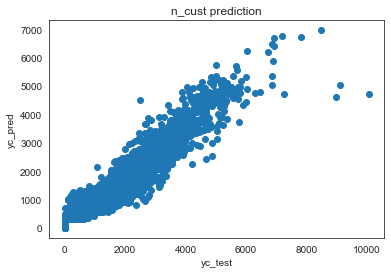

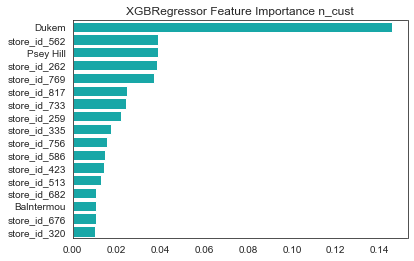

model                                         parameters  \
0         Lasso  {'alpha': 1.0, 'copy_X': True, 'fit_intercept'...   
1  XGBRegressor  {'objective': 'reg:squarederror', 'base_score'...   
2  XGBRegressor  {'objective': 'reg:squarederror', 'base_score'...   
3  XGBRegressor  {'objective': 'reg:squarederror', 'base_score'...   
4  XGBRegressor  {'objective': 'reg:squarederror', 'base_score'...   
5  XGBRegressor  {'objective': 'reg:squarederror', 'base_score'...   

          MAE        RMSE  
0  272.480000  382.750000  
1  170.260129  233.003534  
2  359.456236  503.673256  
3  361.035418  504.523145  
4  167.816365  232.785170  
5  173.736974  246.131963

In [56]:
# run model
start_time = time.time()
xbg_model, yxgc_pred, MAE, RMSE = xgboost(X_train, X_test, yc_train, yc_test)
end_time = time.time()
print(f'Elapsed time = {(end_time - start_time)/60} min ... ')

# plot results
result_plot(yc_test, yxgc_pred, response[0], path='./visuals/scatterplot_xgb_ncust.png')

# feature importance
top_feats, name_list = feature_importance(xbg_model, X, response[0], 0.01)

# save model
path = './data/modelling_results_mae.csv'
ncust_results = load_save_results(path, xbg_model, MAE, RMSE)
ncust_results


### Create Predictions for n_cust 

In [71]:
# new data in correct format
arr_data = new_data.values
print(arr_data.shape)

# prediction
n_cust_pred = xbg_model.predict(arr_data)

# adjust predictions < 0 to 0
for idx, val in enumerate(n_cust_pred): # 4517 predictions under 0
    if val < 0:
        n_cust_pred[idx] = 0
        
n_cust_pred

(34306, 1038)


array([ 839.61536,  839.61536, 1131.1151 , ...,    0.     ,    0.     ,
          0.     ], dtype=float32)

### Revenue

R-squared: 0.83
Mean Squared Error: 4949782.14
Root Mean Squared Error: 2224.81
Mean Absolute Error: 1534.65
Mean Absolute Percentage Error: 5.214367467214057e+16
Elapsed time = 24.563925969600678 min ... 


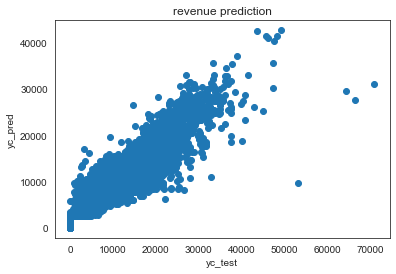

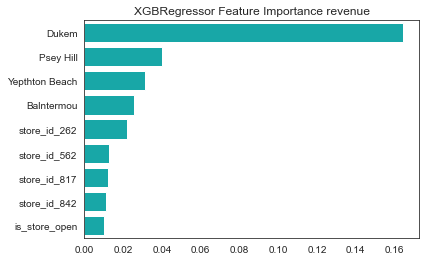

model                                         parameters  \
0  XGBRegressor  {'objective': 'reg:squarederror', 'base_score'...   
1  XGBRegressor  {'objective': 'reg:squarederror', 'base_score'...   

           MAE         RMSE  
0  1565.537094  2245.944976  
1  1534.648491  2224.810586

In [72]:
# run model
start_time = time.time()
xbgr_model, yxgr_pred, MAEr, RMSEr = xgboost(X_train, X_test, yr_train, yr_test)
end_time = time.time()
print(f'Elapsed time = {(end_time - start_time)/60} min ... ')

# plot results
result_plot(yr_test, yxgr_pred, response[1], path='./visuals/scatterplot_xgb_revenue.png')

# feature importance
top_feats_rev, name_list_rev = feature_importance(xbgr_model, X, response[1], 0.01)

# save model
rev_path = './data/modelling_results_mae_revenue.csv'
revenue_results = load_save_results(rev_path, xbgr_model, MAEr, RMSEr)
revenue_results


In [73]:
# predict new data
new_data = load_data(path='./data/clean_prediction_data.csv')
new_data = new_data.iloc[:,1:]
print(new_data.shape)

# new data in correct format
arr_data = np.asarray(new_data)

# predict
revenue_pred = xbgr_model.predict(arr_data)

# adjust predictions < 0 to 0
for idx, val in enumerate(revenue_pred): # 4517 predictions under 0
    if val < 0:
        revenue_pred[idx] = 0
        
revenue_pred

(34306, 1038)


array([8.4198623e+03, 8.4198623e+03, 1.1783347e+04, ..., 8.3786812e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32)

# Output Generation

## Create Prediction File

In [74]:
#pred_data = load_data(path='./data/sales_data_forecast.csv')
pred_data[['n_cust_pred', 'revenue_pred']] = np.nan
pred_data.n_cust_pred = n_cust_pred
pred_data.revenue_pred = revenue_pred
pred_data.head()

# save file
pred_data.to_csv('./data/sales_data_forecast.csv')

In [76]:
pred_data.head()

store_id        date  is_store_open  is_sale_period             town  \
0         1  2012-02-03              1               1   Yepthton Beach   
1         2  2012-02-03              1               1   Yepthton Beach   
2         3  2012-02-03              1               1            Dukem   
3         4  2012-02-03              1               1   Yepthton Beach   
4         5  2012-02-03              1               1  Mount Trancesmi   

   n_cust_pred  revenue_pred  
0   839.615356   8419.862305  
1   839.615356   8419.862305  
2  1131.115112  11783.346680  
3  1323.498779  10242.331055  
4   770.728699   6707.072754

In [77]:
pred_data.describe()

store_id  is_store_open  is_sale_period   n_cust_pred  revenue_pred
count  34306.000000   34306.000000    34306.000000  34306.000000  34306.000000
mean     505.000000       0.855710        0.441176    808.287537   7478.916992
std      291.277313       0.351388        0.496535    535.199280   4432.217773
min        1.000000       0.000000        0.000000      0.000000      0.000000
25%      253.000000       1.000000        0.000000    620.761536   5504.212402
50%      505.000000       1.000000        0.000000    823.605530   7983.159668
75%      757.000000       1.000000        1.000000   1031.389008   9939.020508
max     1009.000000       1.000000        1.000000   7348.543457  42201.589844

### Interpret Results

Error visuals - Notes:
1. Add y_pred to selected_data
2. For store_id in selected_data.store_id.unique():
    for month in selected_data.month.unique()
    print(mean_absolute_error(selected_data[selected_data.store_id == store_id].y_true, selected_data[selected_data.store_id == store_id].y_pred)
3. Highlight stores with higher MAE than the average
4. Break error down accross month. (Additional)

In [78]:
def mae_storeid(y_true, y_pred):
    
    df = result_df.iloc[limit:]
    mae_arr = []

    for store_id in df.store_id.unique():
        storeid_ytrue = df[df.store_id == store_id][y_true]
        storeid_ypred = df[df.store_id == store_id][y_pred]
        mae = mean_absolute_error(storeid_ytrue, storeid_ypred)
        #print(store_id, round(mae,2))
        
        mae_arr.append([store_id, round(mae,2)])
        
    return mae_arr
             

In [79]:
result_df = selected_data.copy()

In [148]:
# -- n_cust
# Add predicted (verification/tune) results to the input data
result_df['n_cust_pred'] = np.nan
result_df['n_cust_pred'].iloc[limit:] = yxgc_pred # test_data index

# for n_cust create mae per store
yc_true = 'n_cust'# result_df.n_cust.iloc[limit:]
yc_pred = 'n_cust_pred' # result_df.ylrc_pred.iloc[limit:] 
mae_ncust = mae_storeid(yc_true, yc_pred)
mae_ncust = pd.DataFrame(mae_ncust)
mae_ncust.columns = ['store_id', 'mae_ncust']

# compare with mean and 
ncust_mean = round(result_df.n_cust.mean(),2)
mae_ncust_mean = round(mae_ncust.mae_ncust.mean(),2)

# compare with current average 
n_cust_results = result_df.groupby(by='store_id')['n_cust'].mean()
n_cust_results = pd.DataFrame(n_cust_results)
compare_ncust = n_cust_results.merge(mae_ncust, on='store_id')
compare_ncust['percentage_error'] = compare_ncust.mae_ncust/compare_ncust.n_cust
mean_per_error = compare_ncust.percentage_error.mean()
compare_ncust.to_csv('./data/results_comparison_ncust.csv')

# results
print(f'{type(xbg_model).__name__} for {response[0]}')
print(f'Average n_cust: {ncust_mean} & average MAE: {mae_ncust_mean} -> {round(100*mae_ncust_mean/ncust_mean,2)}% error')
print(f'The prediction has less than average error for {compare_ncust[compare_ncust.percentage_error < mean_per_error].shape[0]} stores')
#print(f'Average prediction for {mae_ncust[mae_ncust.iloc[:,1] == mae_ncust_mean].shape[0]} stores')
print(f'The prediction has higher than average error for {compare_ncust[compare_ncust.percentage_error > mean_per_error].shape[0]} stores')



XGBRegressor for n_cust
Average n_cust: 773.3 & average MAE: 173.21 -> 22.4%
The prediction has less than average error for 677 stores
The prediction has higher than average error for 332 stores


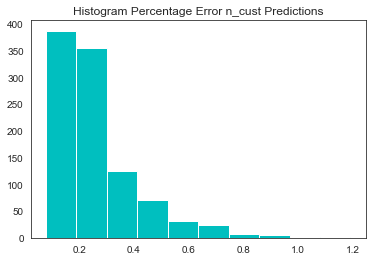

In [158]:
# plot
plt.hist(compare_ncust.percentage_error, color='c');
plt.title('Histogram Percentage Error n_cust Predictions');
plt.savefig(f'./visuals/hist_error_ncust.png', bbox_inches='tight')


In [148]:
# -- n_cust
# Add predicted (verification/tune) results to the input data
result_df['n_cust_pred'] = np.nan
result_df['n_cust_pred'].iloc[limit:] = yxgc_pred # test_data index

# for n_cust create mae per store
yc_true = 'n_cust'# result_df.n_cust.iloc[limit:]
yc_pred = 'n_cust_pred' # result_df.ylrc_pred.iloc[limit:] 
mae_ncust = mae_storeid(yc_true, yc_pred)
mae_ncust = pd.DataFrame(mae_ncust)
mae_ncust.columns = ['store_id', 'mae_ncust']

# compare with mean and 
ncust_mean = round(result_df.n_cust.mean(),2)
mae_ncust_mean = round(mae_ncust.mae_ncust.mean(),2)
mean_per_error = compare_ncust.percentage_error.mean()

# compare with current average 
n_cust_results = result_df.groupby(by='store_id')['n_cust'].mean()
n_cust_results = pd.DataFrame(n_cust_results)
compare_ncust = n_cust_results.merge(mae_ncust, on='store_id')
compare_ncust['percentage_error'] = compare_ncust.mae_ncust/compare_ncust.n_cust
compare_ncust.to_csv('./data/results_comparison_ncust.csv')

# results
print(f'{type(xbg_model).__name__} for {response[0]}')
print(f'Average n_cust: {ncust_mean} & average MAE: {mae_ncust_mean} -> {round(100*mae_ncust_mean/ncust_mean,2)}% error')
print(f'The prediction has less than average error for {compare_ncust[compare_ncust.percentage_error < mean_per_error].shape[0]} stores')
#print(f'Average prediction for {mae_ncust[mae_ncust.iloc[:,1] == mae_ncust_mean].shape[0]} stores')
print(f'The prediction has higher than average error for {compare_ncust[compare_ncust.percentage_error > mean_per_error].shape[0]} stores')



XGBRegressor for n_cust
Average n_cust: 773.3 & average MAE: 173.21 -> 22.4%
The prediction has less than average error for 677 stores
The prediction has higher than average error for 332 stores


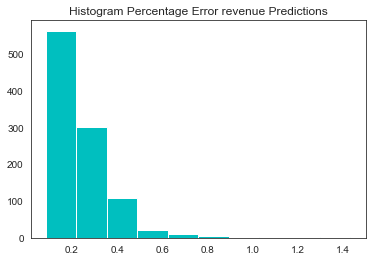

In [159]:
# plot
plt.hist(compare_rev.percentage_error, color='c');
plt.title('Histogram Percentage Error revenue Predictions');
plt.savefig(f'./visuals/hist_error_rev.png', bbox_inches='tight')

